# Run In-Silico CSM

In [2]:
# import basic functionality / libs
import sys
import os
import numpy as np
import pandas as pd
import json
import scipy
import collections

from sklearn.preprocessing import MinMaxScaler, StandardScaler

sys.path.append('../../')
from eztrack.edp.loaders.patient.subjectresultsloader import SubjectResultsLoader
from eztrack.edp.loaders.dataset.result.resultloader import ResultLoader
from eztrack.edp.loaders.centerdata import CenterLoader
from eztrack.edm.classifiers.model.cez_oez_analyzer import FragilitySplitAnalyzer

# import fragility related modulesl
from eztrack.edm.fragility.model.impulsemodel import ImpulseModel

from eztrack.edv.plot_fragility_heatmap import PlotFragilityHeatmap
from eztrack.edv.baseplot import BasePlotter
from eztrack.edp.utils.post_process import PostProcess
from eztrack.edp.utils.utils import map_to_win, compute_timepoints

%matplotlib inline
# import basic plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

# Import magic commands for jupyter notebook 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def time_warp_seizure(mat, onsetwin, offsetwin, bufferwin):
    # parameters of the resampling length
    ICTAL_LEN = 100
    PREICTAL_LEN = POSTICTAL_LEN = 30
    
    # trim matrix
    mat = mat[...,onsetwin-bufferwin:offsetwin+bufferwin]

    # warp the ictal region
    warped_ictal = PostProcess.resample_mat(mat[..., bufferwin:-bufferwin],
                                            ICTAL_LEN)

    # get the preictal region
    preictal_mat = PostProcess.resample_mat(mat[...,0:bufferwin],
                                            PREICTAL_LEN)

    # get the postictal region
    postictal_mat = PostProcess.resample_mat(mat[...,-bufferwin:],
                                             POSTICTAL_LEN)

    # concatenate preictal, ictal and postictal warped region
    mat = np.concatenate((preictal_mat, warped_ictal, postictal_mat), axis=-1)
    return mat

In [4]:
def plot_map(mat, labels, onsetchans, onsetwin, offsetwin, figdir, outputfigurename,
            titlestr=""):
    if titlestr == "":
        titlestr = "Impulse Response Map iEEG"
        
    outputfigurename = os.path.splitext(outputfigurename)[0]

    plotter = PlotFragilityHeatmap(figdir)

    vertlines = [onsetwin, offsetwin]
    if onsetwin is None:
        vertlines = []
    elif offsetwin is None:
        vertlines = [onsetwin]

#     print(onsetchans)
#     print(labels)
#     print(vertlines)
    fig, ax = plotter.plot_fragility_map(mat, labels, onsetchans, spreadchans=[], vertlines=vertlines,
                               titlestr=titlestr,save=False,
                               figure_name="{}".format(outputfigurename), 
                               cbarlabel="Z-normalized L2-Norm of Response")
    
    return fig,ax

In [5]:
def create_impulse_maps(impulseresponses, indslist):
    # create a dictionary of all the impulse maps
    impulse_maps = dict()

    scaler = StandardScaler()
#     scaler = MinMaxScaler()
    
    # go through each of the onset contacts and create impulse response maps
    for i, ind in enumerate(indslist):
        # propagation map
        propagation_map = []
        # ranked order of response magnitudes
        rankorder_map = []

        # loop through time axis for each matrix of responses from this channel
        for j in range(len(impulseresponses)):
            currimpulse = impulseresponses[j]

            # get the corresponding l2 norm responses from this channel
            l2_norm_responses = currimpulse[ind,:]
            # apply normalization to the normed responses
            l2_norm_responses = scaler.fit_transform(l2_norm_responses[:,np.newaxis])

            # print a debug statement on the data shapes
            if i == 0 and j == 0:
                print("ImpResponse shape, current response shape, l2norm vec shape: ", 
                      impulseresponses.shape, currimpulse.shape, l2_norm_responses.shape)

            # rank order them
            sorted_inds = np.argsort(l2_norm_responses, axis=-1, kind='mergesort')

            # append each node's response to the propagation map
            propagation_map.append(l2_norm_responses.squeeze())
            # store the rank order mapping
            rankorder_map.append(sorted_inds.squeeze())

        propagation_map = np.array(propagation_map).T
        # store the impulse map
        impulse_maps[chanlabels[ind]] = propagation_map
        
    return impulse_maps

# Setup Data Directories

In [13]:
center = 'nih'
reference = 'monopolar'
modality = 'ieeg'
patid = 'pt6'

# patid = 'la08'
# dataset_id = 'sz1pg'

basedir = '/Users/adam2392/Downloads/output_new/impulsemodel/'
# basedir = "/home/adam2392/hdd/data/processed/output_new/impulsemodel/"

resultsdir = os.path.join(basedir, '{reference}/{modality}/{center}'.
                          format(reference=reference,
                                modality=modality,
                                 center = center))

print(resultsdir)

/Users/adam2392/Downloads/output_new/impulsemodel/monopolar/ieeg/nih


In [6]:
figdir = "/Users/adam2392/Downloads/figures/impulse_responses/{}".format(patid)
# figdir = "/home/adam2392/Downloads/figures/impulse_responses/{}".format(patid)

if not os.path.exists(figdir):
    os.makedirs(figdir)

In [46]:
patientloader = SubjectResultsLoader(subjid=patid,
                            preload=False,
                            datatype='impulse',
                            root_dir=resultsdir)

print(patientloader.jsonfilepaths)
print("Finished loading in data for this patient")

Already renamed seeg.xyz
Already renamed gain.mat
Found 3 jsonfilepaths for pt6
['pt6_sz_3_impulse_responses.json', 'pt6_sz_4_impulse_responses.json', 'pt6_sz_5_impulse_responses.json']
Finished loading in data for this patient


In [47]:
# load all results
patientloader.read_all_files()

Loading results data from:  /Users/adam2392/Downloads/output_new/impulsemodel/monopolar/ieeg/nih/pt6_sz_3_impulse_responses.npz
Loading results data from:  /Users/adam2392/Downloads/output_new/impulsemodel/monopolar/ieeg/nih/pt6_sz_4_impulse_responses.npz
Loading results data from:  /Users/adam2392/Downloads/output_new/impulsemodel/monopolar/ieeg/nih/pt6_sz_5_impulse_responses.npz


In [25]:
allpats = [
#     'pt1', 'pt6',
    'jh105', 'jh108'
#     'la02', 'la08'
]

center = 'jhu'
reference = 'monopolar'
modality = 'ieeg'
resultsdir = os.path.join('/Users/adam2392/Downloads/output_new/impulsemodel/{reference}/{modality}/'.
                          format(reference=reference,
                                modality=modality), 
                          center)

In [26]:
centerloader = CenterLoader(centername=center, 
                            subjids=allpats,
                            preload=False,
                            datatype='impulse',
                            root_dir=resultsdir)
print(centerloader.subjids)

Already renamed seeg.xyz
Already renamed gain.mat
['jh105', 'jh108']


In [27]:
centerloader.read_all_files()

Already renamed seeg.xyz
Already renamed gain.mat
Found 5 jsonfilepaths for jh105
Loading results data from:  /Users/adam2392/Downloads/output_new/impulsemodel/monopolar/ieeg/jhu/jh105_sz_1_impulse_responses.npz
Loading results data from:  /Users/adam2392/Downloads/output_new/impulsemodel/monopolar/ieeg/jhu/jh105_sz_2_impulse_responses.npz
Loading results data from:  /Users/adam2392/Downloads/output_new/impulsemodel/monopolar/ieeg/jhu/jh105_sz_3_impulse_responses.npz
Loading results data from:  /Users/adam2392/Downloads/output_new/impulsemodel/monopolar/ieeg/jhu/jh105_sz_4_impulse_responses.npz
Loading results data from:  /Users/adam2392/Downloads/output_new/impulsemodel/monopolar/ieeg/jhu/jh105_sz_5_impulse_responses.npz
Already renamed seeg.xyz
Already renamed gain.mat
Found 6 jsonfilepaths for jh108
Loading results data from:  /Users/adam2392/Downloads/output_new/impulsemodel/monopolar/ieeg/jhu/jh108_sz_2_impulse_responses.npz
Loading results data from:  /Users/adam2392/Downloads/ou

../../edp/loaders/base/basemultipleloader.py:332: UserWarning: All attributes engelscore should be the same here!
  warnings.warn("All attributes {} should be the same here!".format(name))
../../edp/loaders/base/basemultipleloader.py:332: UserWarning: All attributes engelscore should be the same here!
  warnings.warn("All attributes {} should be the same here!".format(name))
../../edp/loaders/base/basemultipleloader.py:332: UserWarning: All attributes engelscore should be the same here!
  warnings.warn("All attributes {} should be the same here!".format(name))
../../edp/loaders/base/basemultipleloader.py:332: UserWarning: All attributes engelscore should be the same here!
  warnings.warn("All attributes {} should be the same here!".format(name))
../../edp/loaders/base/basemultipleloader.py:332: UserWarning: All attributes engelscore should be the same here!
  warnings.warn("All attributes {} should be the same here!".format(name))
../../edp/loaders/base/basemultipleloader.py:332: UserW

([<edp.base.objects.dataset.perturbationresult_object.ImpulseResult at 0x1c261d8160>,
 ['jh105',
  'jh105',
  'jh105',
  'jh105',
  'jh105',
  'jh108',
  'jh108',
  'jh108',
  'jh108',
  'jh108',
  'jh108'],
 ['sz_1',
  'sz_2',
  'sz_3',
  'sz_4',
  'sz_5',
  'sz_2',
  'sz_3',
  'sz_4',
  'sz_5',
  'sz_6',
  'sz_7'])

In [17]:
ccresults = centerloader.get_results()

print([x.shape for x in ccresults])

[(3847, 62, 62), (3525, 88, 88), (4327, 88, 88)]


In [28]:
jhuresults = centerloader.get_results()

print([x.shape for x in jhuresults])

[(1448, 85, 85), (1448, 85, 85), (1448, 85, 85), (1376, 85, 85), (1496, 85, 85), (1159, 136, 136), (1631, 136, 136), (1448, 136, 136), (1375, 136, 136), (1448, 136, 136), (1375, 136, 136)]


In [21]:
nihresults = centerloader.get_results()

print([x.shape for x in nihresults])

[(2151, 86, 86), (2841, 86, 86), (2967, 86, 86), (2488, 86, 86), (3032, 81, 81), (3297, 81, 81), (3376, 81, 81)]


In [89]:
allresults = ccresults.tolist()
allresults.extend(nihresults.tolist())
allresults.extend(jhuresults.tolist())

print(len(allresults))

21


# Create Patient Results Dict Collections

In [90]:
patresult_dict = collections.defaultdict(list)
print(patresult_dict)

defaultdict(<class 'list'>, {})


In [91]:
patcezinds_dict = dict()

In [96]:
# loop through all results
for i, impulsemodel in enumerate(allresults):
    impulseresponses = impulsemodel.get_data()
    print(impulseresponses.shape)
    
    # initialize metadata necessary for plotting
    samplerate = impulsemodel.samplerate
    chanlabels = impulsemodel.chanlabels
    onsetwin = impulsemodel.onsetwin
    offsetwin = impulsemodel.offsetwin
    cezcontacts = impulsemodel.cezcontacts
    dataset_id = impulsemodel.dataset_id
    patient_id = impulsemodel.patient_id
    cezinds = impulsemodel.cezinds
    otherinds = [ind for ind in range(len(chanlabels)) if ind not in ieegcezinds]

    print("Looking at: ", patient_id, dataset_id)
    print(impulseresponses.shape)
    print(cezcontacts)
    print(onsetwin, offsetwin, len(chanlabels))
    
    # create impulse maps
    all_impulse_maps = create_impulse_maps(impulseresponses, np.arange(len(chanlabels)))
    
    all_map = []

    for ind in all_impulse_maps.keys():
        currimpmap = all_impulse_maps[ind]
        all_map.append(currimpmap)
    all_map = np.array(all_map)
    print(all_map.shape)

    # combine into the response map
    all_map = np.mean(all_map, axis=0)
    
    bufferind = 15*samplerate
    bufferwin = map_to_win(bufferind, impulsemodel.samplepoints)
    
    if onsetwin is None:
        onsetwin = bufferwin
    if offsetwin is None:
        offsetwin = all_map.shape[1] - bufferwin
    
    # time warp
    response_map = time_warp_seizure(all_map, onsetwin, offsetwin, bufferwin)
    
    # append the dataset for this patient - that is timewarped 
    patresult_dict[patient_id].append(response_map)
    patcezinds_dict[patient_id] = cezinds
    
    print(response_map.shape)
    print(all_map.shape)

(3847, 62, 62)
Looking at:  la02 sz
(3847, 62, 62)
["l'2", "l'3", "l'4"]
2876 3070 62
ImpResponse shape, current response shape, l2norm vec shape:  (3847, 62, 62) (62, 62) (62, 1)
(62, 62, 3847)
(62, 160)
(62, 3847)
(3525, 88, 88)
Looking at:  la08 1pg
(3525, 88, 88)
['q2']
961 1817 88
ImpResponse shape, current response shape, l2norm vec shape:  (3525, 88, 88) (88, 88) (88, 1)
(88, 88, 3525)
(88, 160)
(88, 3525)
(4327, 88, 88)
Looking at:  la08 sz
(4327, 88, 88)
['q2']
2875 3819 88
ImpResponse shape, current response shape, l2norm vec shape:  (4327, 88, 88) (88, 88) (88, 1)
(88, 88, 4327)
(88, 160)
(88, 4327)
(2151, 86, 86)
Looking at:  pt1 sz_2
(2151, 86, 86)
['pd1', 'pd2', 'pd3', 'pd4', 'ad1', 'ad2', 'ad3', 'ad4', 'att1', 'att2']
606 1293 86
ImpResponse shape, current response shape, l2norm vec shape:  (2151, 86, 86) (86, 86) (86, 1)
(86, 86, 2151)
(86, 160)
(86, 2151)
(2841, 86, 86)
Looking at:  pt1 sz_3
(2841, 86, 86)
['pd1', 'pd2', 'pd3', 'pd4', 'ad1', 'ad2', 'ad3', 'ad4', 'att1'

In [97]:
print(onsetwin, offsetwin)
print(patresult_dict.keys(), patcezinds_dict.keys())
# print(len(allresults))
# bufferind = 15*impulsemodel.samplerate
# bufferwin = map_to_win(bufferind, impulsemodel.samplepoints)
    
# response_map = time_warp_seizure(all_map, onsetwin, offsetwin, bufferwin)
# print(response_map.shape)  

470 1256
dict_keys(['la02', 'la08', 'pt1', 'pt6', 'jh105', 'jh108']) dict_keys(['la02', 'la08', 'pt1', 'pt6', 'jh105', 'jh108'])


In [98]:
np.savez("/Users/adam2392/Downloads/allmap_embc.npz", mat=patresult_dict, 
                                             inds=patcezinds_dict)

In [99]:
print("Done")

Done


# Load Data and Run CEZ/OEZ Analysis

In [10]:
results = np.load("/Users/adam2392/Downloads/allmap_embc.npz", encoding="latin1")
allmat = results['mat'].item()
allinds = results['inds'].item()

print(allinds.keys())
print(allmat.keys())

patresult_dict = allmat
patcezinds_dict = allinds

dict_keys(['la02', 'la08', 'pt1', 'pt6', 'jh105', 'jh108'])
dict_keys(['la02', 'la08', 'pt1', 'pt6', 'jh105', 'jh108'])


In [13]:
outcome_mapping = {
    'la02': 's',
    'la08': 'f',
    'pt1': 's',
    'pt6': 'f',
    'jh105': 's',
    'jh108': 'f'
}


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Looking at:  la02
(160,) (160,)
(160,) (160,)
Looking at:  la08
(160,) (160,)
(160,) (160,)
(160,) (160,)
(160,) (160,)
Looking at:  pt1
(160,) (160,)
(160,) (160,)
(160,) (160,)
(160,) (160,)
(160,) (160,)
(160,) (160,)
(160,) (160,)
(160,) (160,)
Looking at:  pt6
(160,) (160,)
(160,) (160,)
(160,) (160,)
(160,) (160,)
(160,) (160,)
(160,) (160,)
Looking at:  jh105
(160,) (160,)
(160,) (160,)
(160,) (160,)
(160,) (160,)
(160,) (160,)
Looking at:  jh108
(160,) (160,)
(160,) (160,)
(160,) (160,)
(160,) (160,)
(160,) (160,)
(160,) (160,)


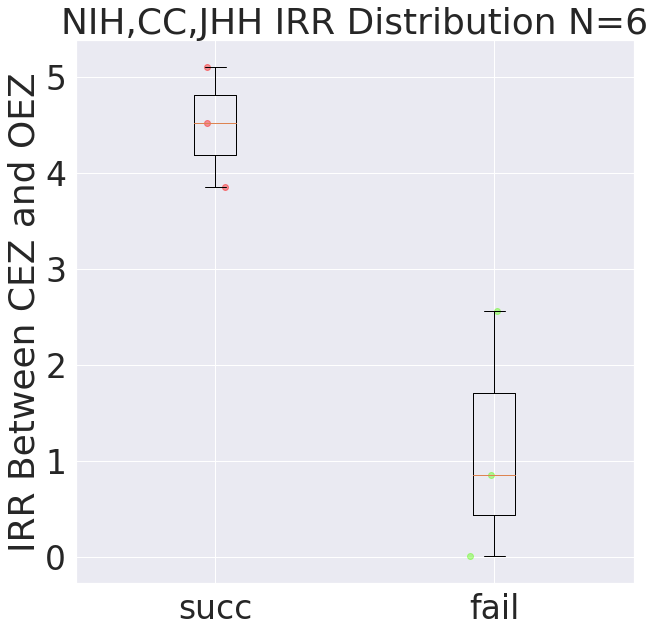

In [103]:
success_irr = []
failed_irr = []

# go through each patient's results
for pat in patresult_dict.keys():
    print("Looking at: ", pat)
    patresults = patresult_dict[pat]
    
    # get the cez/oez inds
    cezinds = patcezinds_dict[pat]
    otherinds = [ind for ind in range(patresults[0].shape[0]) if ind not in cezinds]

    pat_irr = []
    # loop through each cez/oez
    for mat in patresults:
        # create cez/oez mat -> combine
        cezmat = mat[cezinds,:]
        oezmat = mat[otherinds,:]
        
        # apply threshold floor
        cezmat[cezmat < 0] = 0
        oezmat[oezmat < 0] = 0
        
        # combine the matrices together
        cezmat = np.mean(cezmat, axis=0)
        oezmat = np.mean(oezmat, axis=0)
    
        print(cezmat.shape, oezmat.shape)
        
        # create IRR metric
        irr = np.mean(cezmat) / np.mean(oezmat)
        
        pat_irr.append(irr)
        
    pat_irr = np.mean(pat_irr)
    # separate into success/failures -> plot box plot
    outcome = outcome_mapping[pat]
    if outcome == 's':
        success_irr.append(pat_irr)
    elif outcome == 'f':
        failed_irr.append(pat_irr)

# get total number of sz's
numevents = len(success_irr) + len(failed_irr)

# make box plot
sns.set(font_scale=3.0)
fix, ax = plt.subplots(1,1, figsize=(10,10))
# ax = axs[0]
ax.boxplot([success_irr, failed_irr], labels=['succ', 'fail'])
ax.set_title("NIH,CC,JHH IRR Distribution N={}".format(6))
ax.set_ylabel("IRR Between CEZ and OEZ")

names, vals, xs = [], [] ,[]

for i, irrvals in enumerate([success_irr, failed_irr]):
    vals.append(irrvals)
    xs.append(np.random.normal(i+1, 0.04, len(irrvals)))

ngroup = 2
clevels = np.linspace(0., 1., ngroup)

for x, val, clevel in zip(xs, vals, clevels):
    plt.scatter(x, val, c=plt.cm.prism(clevel), alpha=0.4)

# Visualize Example Heatmaps

In [116]:
patid = 'pt6'
resultsdir = "/Users/adam2392/Downloads/output_new/impulsemodel/monopolar/ieeg/nih/"

patientloader = SubjectResultsLoader(subjid=patid,
                            preload=True,
                            datatype='impulse',
                            root_dir=resultsdir)

print(patientloader.jsonfilepaths)
print("Finished loading in data for this patient")

Already renamed seeg.xyz
Already renamed gain.mat
Found 3 jsonfilepaths for pt6
Loading results data from:  /Users/adam2392/Downloads/output_new/impulsemodel/monopolar/ieeg/nih/pt6_sz_3_impulse_responses.npz
Loading results data from:  /Users/adam2392/Downloads/output_new/impulsemodel/monopolar/ieeg/nih/pt6_sz_4_impulse_responses.npz
Loading results data from:  /Users/adam2392/Downloads/output_new/impulsemodel/monopolar/ieeg/nih/pt6_sz_5_impulse_responses.npz
['pt6_sz_3_impulse_responses.json', 'pt6_sz_4_impulse_responses.json', 'pt6_sz_5_impulse_responses.json']
Finished loading in data for this patient


(3032, 81, 81)
ImpResponse shape, current response shape, l2norm vec shape:  (3032, 81, 81) (81, 81) (81, 1)
(81, 81, 3032)
[69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
(81, 3032) 81


../../edv/baseplot.py:126: UserWarning: Noninteractive matplotlib backend! No highlighting functionality in plots!
  "Noninteractive matplotlib backend! No highlighting functionality in plots!")


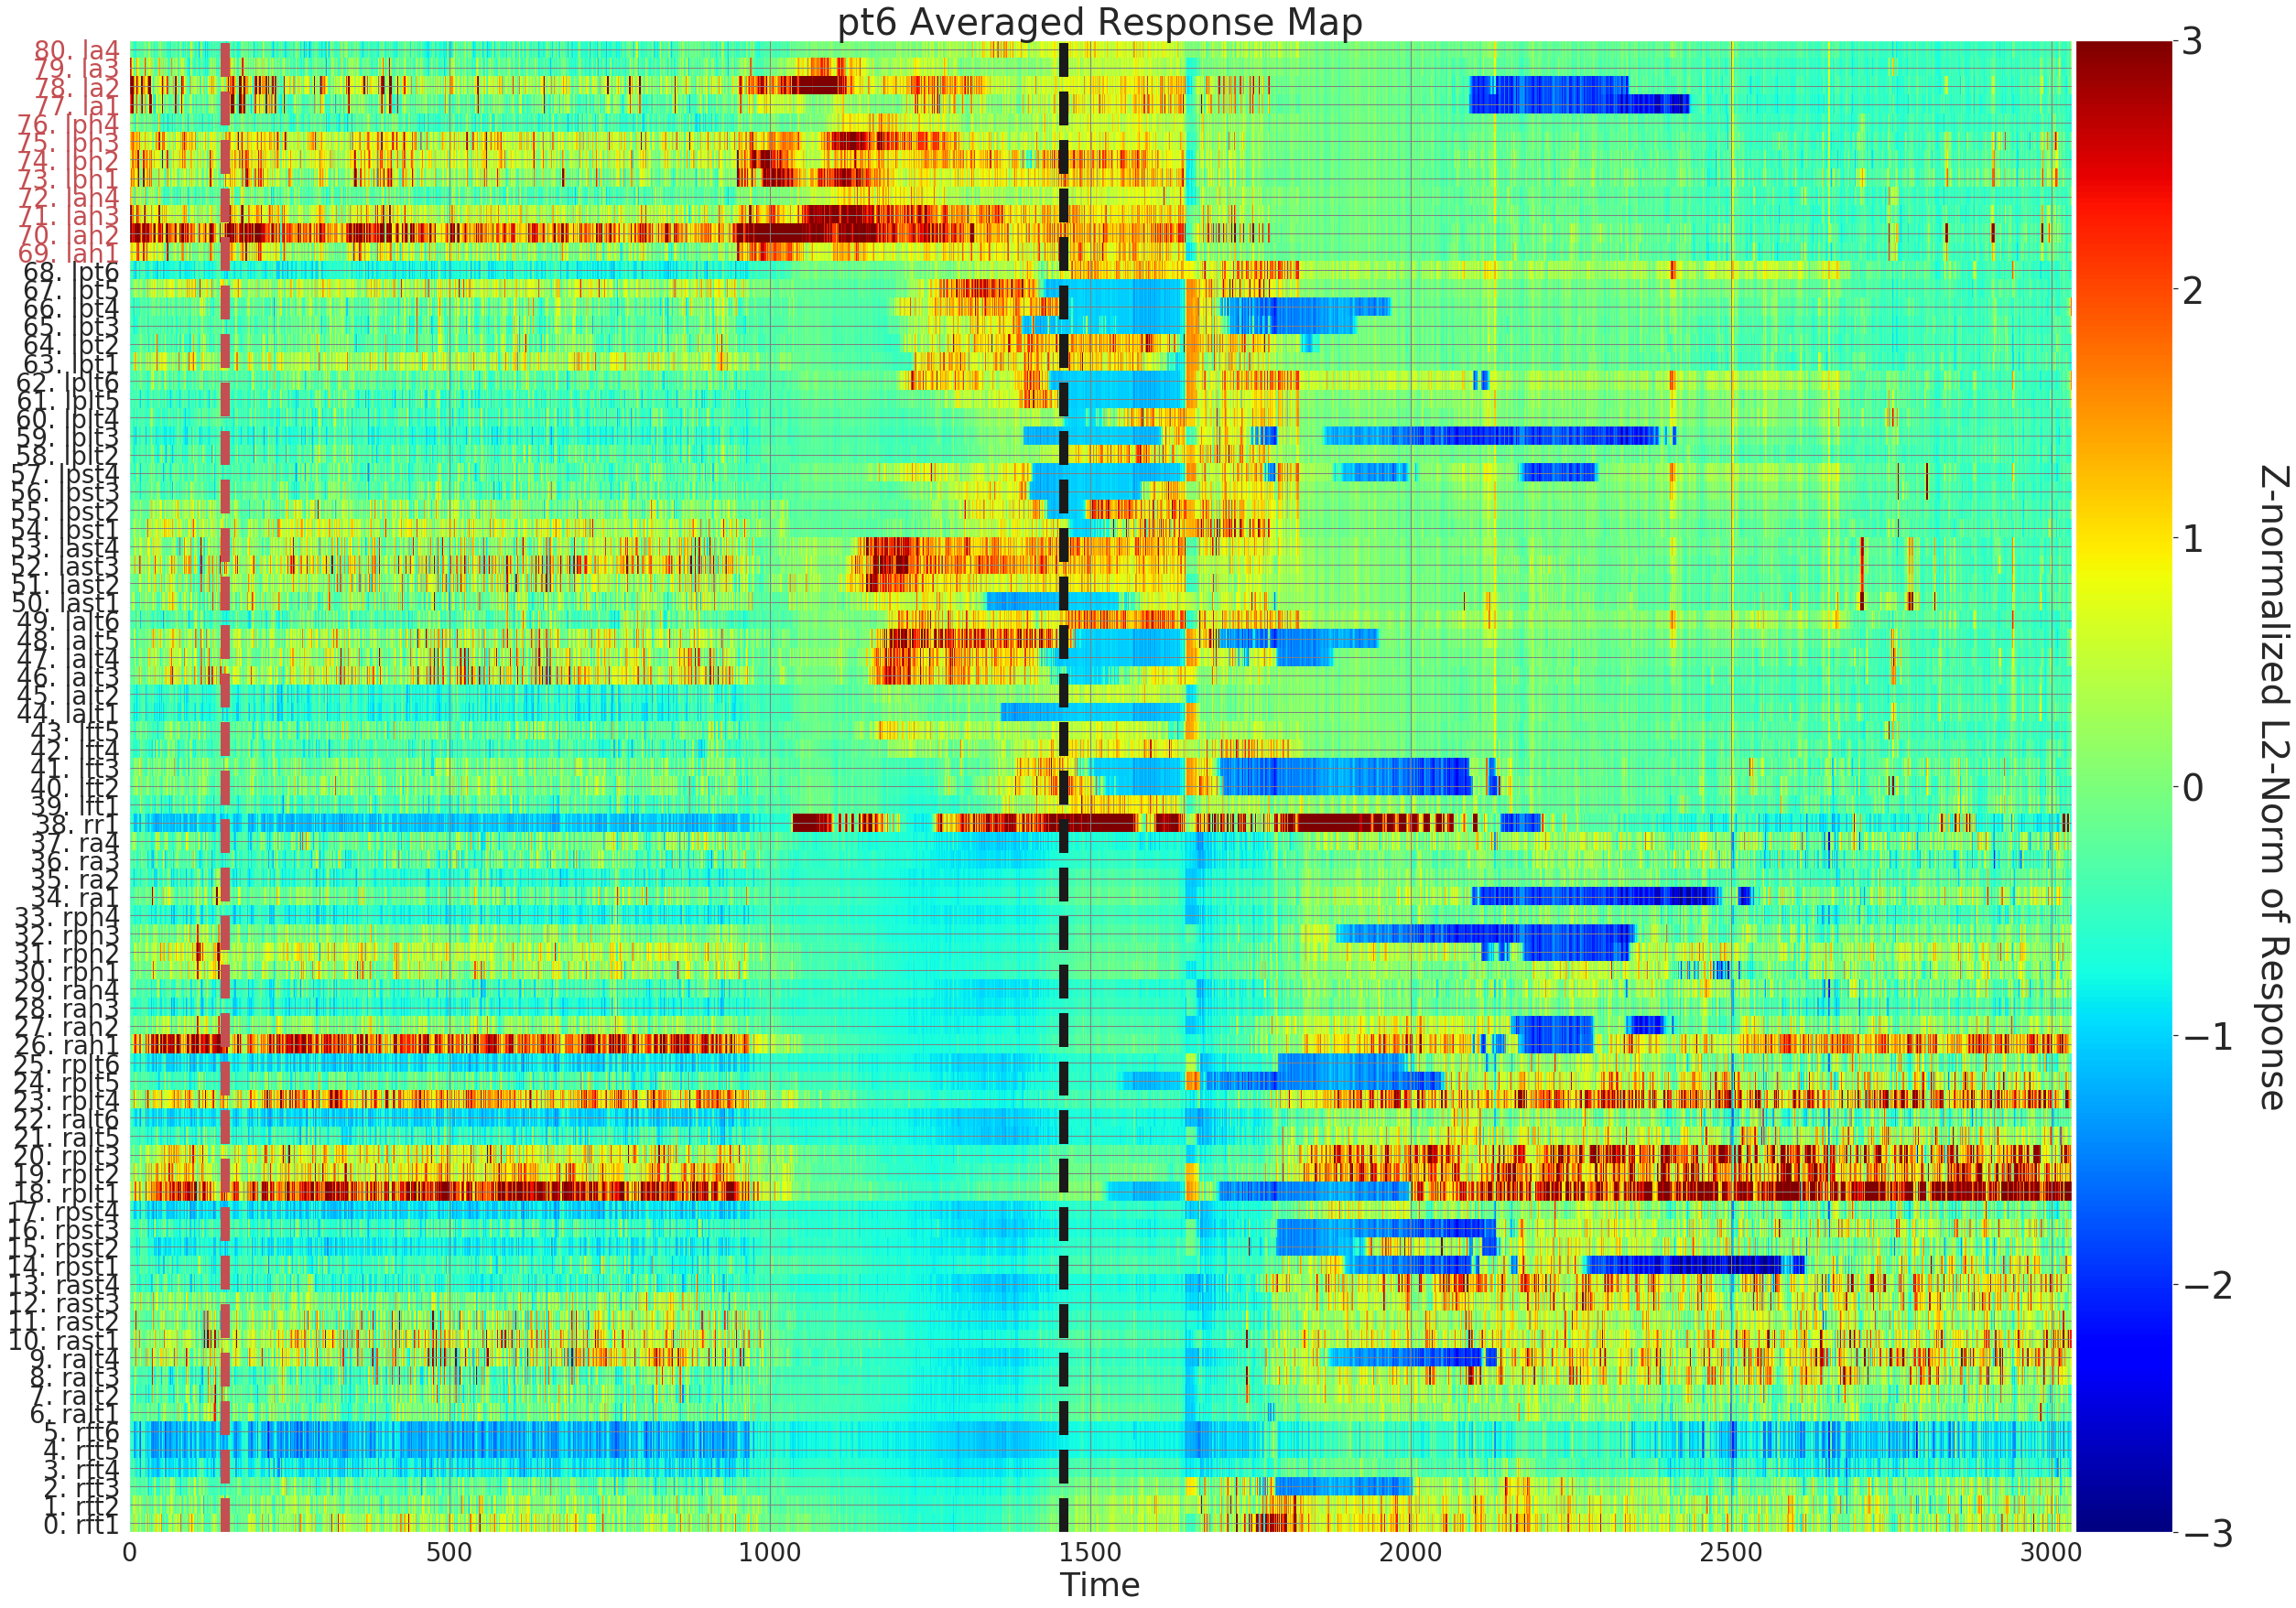

In [117]:
# load all data for this patient and create impulse maps that are cez/oez split
for impulsemodel in patientloader.get_results():
    impulseresponses = impulsemodel.get_data()
    print(impulseresponses.shape)
    
    # initialize metadata necessary for plotting
    chanlabels = impulsemodel.chanlabels
    onsetwin = impulsemodel.onsetwin
    offsetwin = impulsemodel.offsetwin
    ieegcezinds = impulsemodel.cezinds
    cezcontacts = impulsemodel.cezcontacts
    dataset_id = impulsemodel.dataset_id
    otherinds = [ind for ind in range(len(chanlabels)) if ind not in ieegcezinds]
    
    # create impulse maps
    all_impulse_maps = create_impulse_maps(impulseresponses, 
                                       np.arange(len(chanlabels)))
    
    all_map = []

    for ind in all_impulse_maps.keys():
        currimpmap = all_impulse_maps[ind]
        all_map.append(currimpmap)
    all_map = np.array(all_map)
    print(all_map.shape)

    # combine
    all_map = np.mean(all_map, axis=0)

    titlestr = "{} Averaged Response Map".format(patid)
    outputfigurepath = "{}_impulse_response.png".format(patid)

#     sns.set(font_scale=2.0)
    fig, ax = plot_map(all_map, chanlabels, 
                       cezcontacts, onsetwin, offsetwin, 
         figdir, outputfigurepath, titlestr)
    
    fontsize = 55
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize / 2.0)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize / 2.0)

    for im in ax.get_images():
        im.set_clim(-3,3)
    ax.set_xlabel("Time")
    
    plt.savefig(os.path.join(figdir, outputfigurepath))
    
    break

../../edv/baseplot.py:126: UserWarning: Noninteractive matplotlib backend! No highlighting functionality in plots!
  "Noninteractive matplotlib backend! No highlighting functionality in plots!")


[69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
(81, 3032) 81


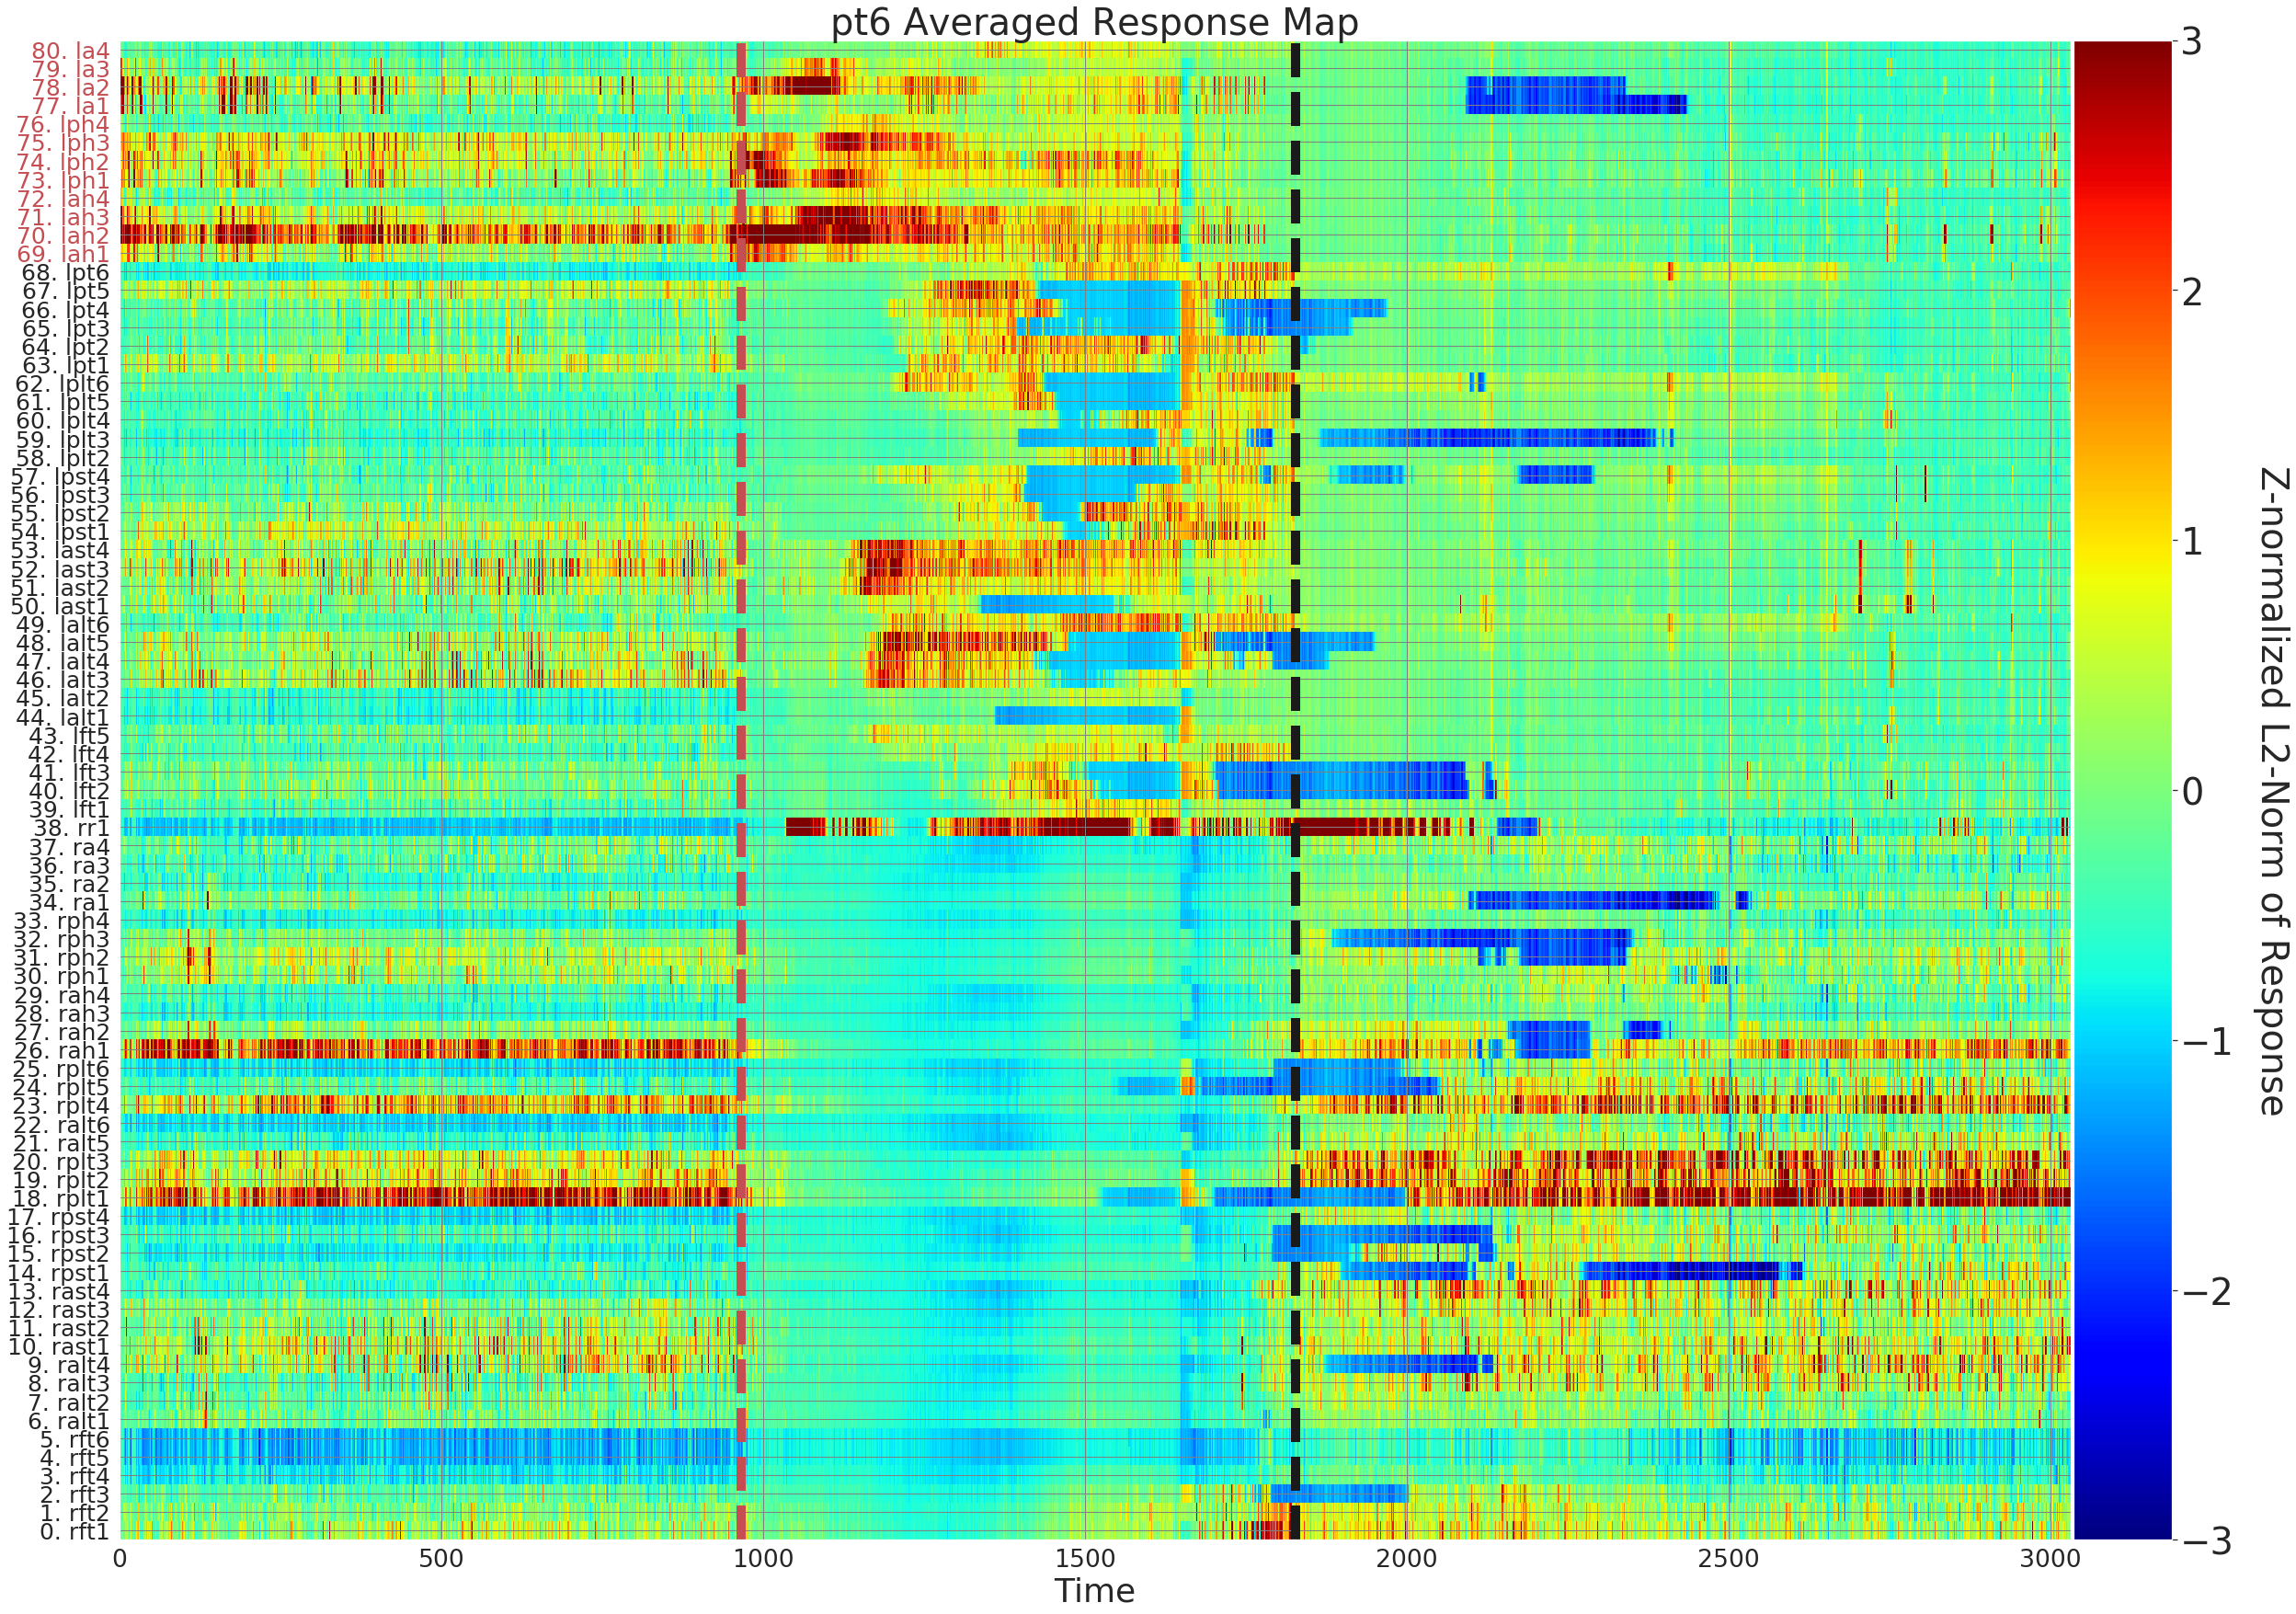

In [121]:
titlestr = "{} Averaged Response Map".format(patid)
outputfigurepath = "{}_impulse_response.png".format(patid)

sns.set(font_scale=3.0)
fig, ax = plot_map(all_map, chanlabels, 
                   cezcontacts, onsetwin, offsetwin, 
     figdir, outputfigurepath, titlestr)

fontsize = 50
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize / 2.0)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)


for im in ax.get_images():
    im.set_clim(-3,3)
ax.set_xlabel("Time")

plt.savefig(os.path.join(figdir, outputfigurepath))


# Onset Likelihood Maps Via Cortical Stimulation Mappin

1. For each channel, generate heatmap of l2 norm of the responses to the impulse

(3032, 81, 81)
(3032, 81, 81)
['la1', 'la2', 'la3', 'la4', 'lah1', 'lah2', 'lah3', 'lah4', 'lph1', 'lph2', 'lph3', 'lph4']
99
966 1828 81
[69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
ImpResponse shape, current response shape, l2norm vec shape:  (1162, 81, 81) (81, 81) (81, 1)
(81, 81, 1162)
[69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
(81, 1162) 81


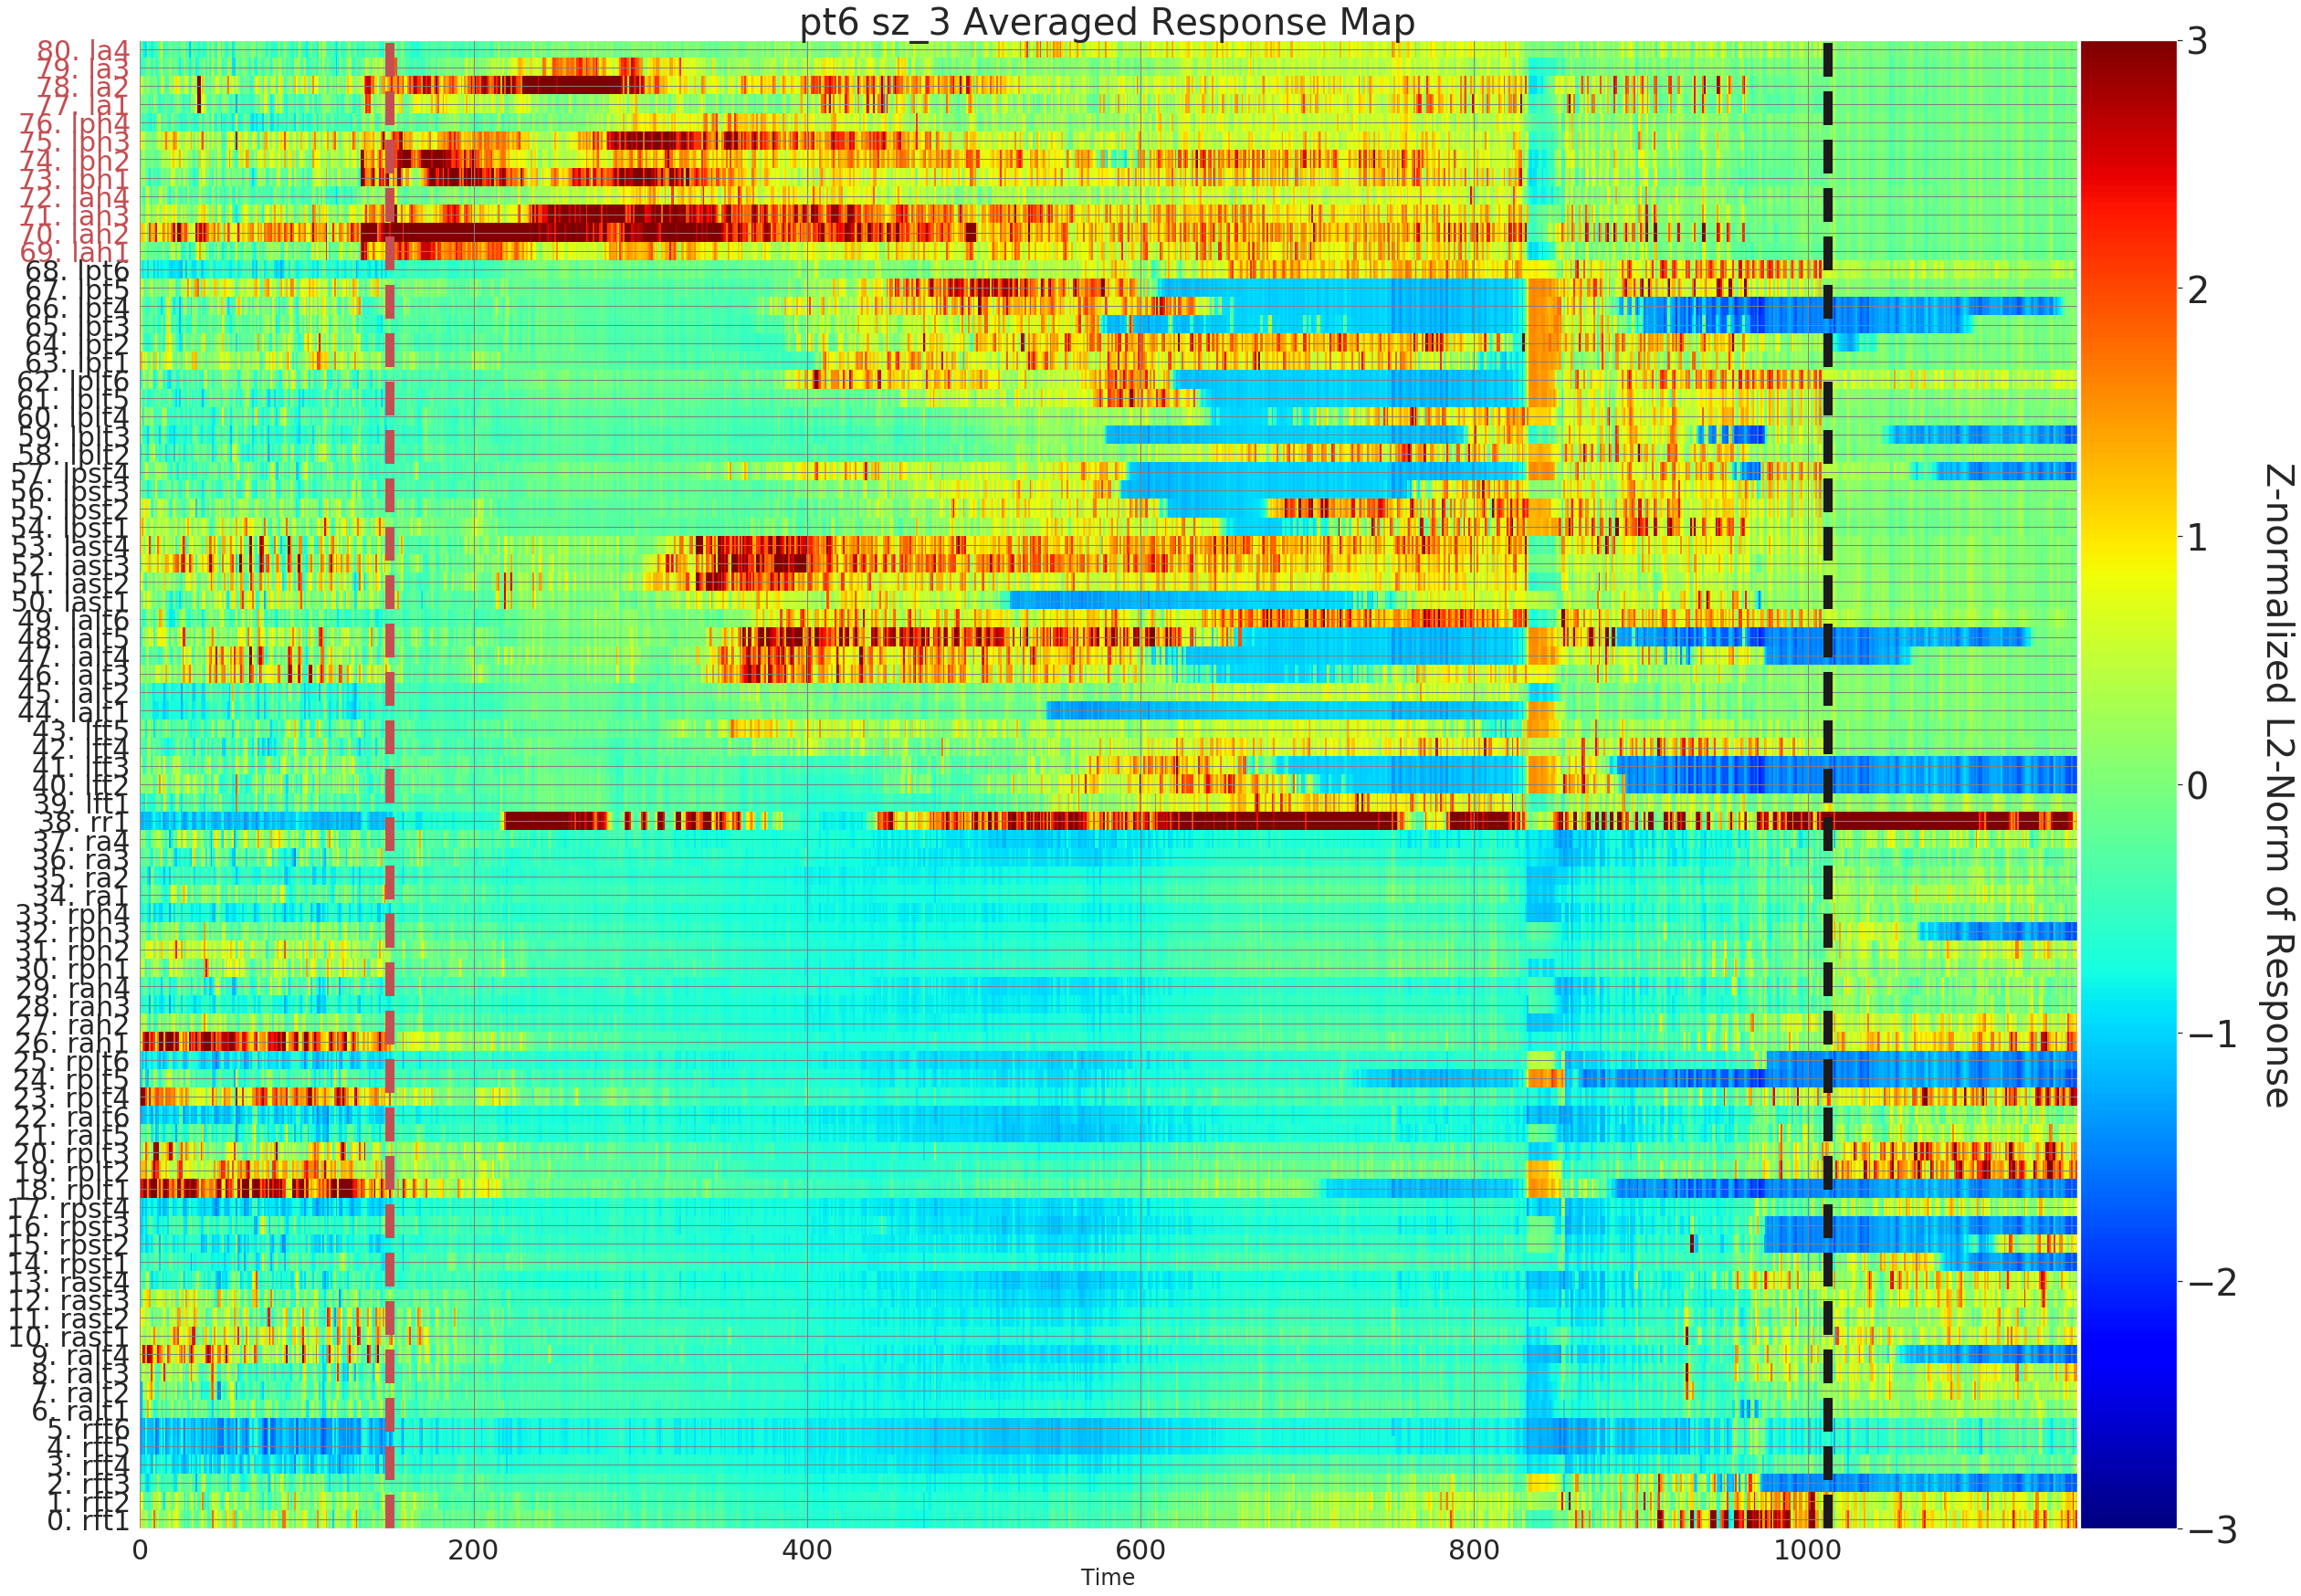

In [48]:
# load all data for this patient and create impulse maps that are cez/oez split
for impulsemodel in patientloader.get_results():
    impulseresponses = impulsemodel.get_data()
    print(impulseresponses.shape)
    
    # initialize metadata necessary for plotting
    chanlabels = impulsemodel.chanlabels
    onsetwin = impulsemodel.onsetwin
    offsetwin = impulsemodel.offsetwin
    ieegcezinds = impulsemodel.cezinds
    cezcontacts = impulsemodel.cezcontacts
    dataset_id = impulsemodel.dataset_id
    otherinds = [ind for ind in range(len(chanlabels)) if ind not in ieegcezinds]

    # trim out the impulseresponses
    numwins_per_sec = 10
    numsecs_offset = 15
    buffer = numwins_per_sec * numsecs_offset
    trimmed_impulse_responses = impulseresponses[onsetwin-buffer:offsetwin+buffer,
                                                         ...]
    newonsetwin = buffer
    newoffsetwin = len(trimmed_impulse_responses) - buffer

    print(impulseresponses.shape)
    print(cezcontacts)
    print(dataset.numberchans)
    print(onsetwin, offsetwin, len(chanlabels))
    print(ieegcezinds)
    # print(otherinds)
    
    # create impulse maps
    all_impulse_maps = create_impulse_maps(impulseresponses, 
                                       np.arange(len(chanlabels)), onsetwin, offsetwin)
    
    all_map = []

    for ind in all_impulse_maps.keys():
        currimpmap = all_impulse_maps[ind]
        all_map.append(currimpmap)
    all_map = np.array(all_map)
    print(all_map.shape)

    # combine
    all_map = np.mean(all_map, axis=0)

    titlestr = "{} {} Averaged Response Map".format(patid, dataset_id)
    outputfigurepath = "{}_{}_impulse_response.png".format(patid, 
                                                          dataset.dataset_id)

#     sns.set(font_scale=2.0)
    fig, ax = plot_map(all_map, chanlabels, 
                       cezcontacts, newonsetwin, newoffsetwin, 
         figdir, outputfigurepath, titlestr)
    
    fontsize = 60
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize / 2.0)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize / 2.0)

    for im in ax.get_images():
        im.set_clim(-3,3)
    ax.set_xlabel("Time")
    
    plt.savefig(os.path.join(figdir, outputfigurepath))
    
    break

In [201]:
# create cez impulse maps
cez_impulse_maps = create_impulse_maps(impulseresponses, ieegcezinds, onsetwin, offsetwin)

In [162]:
# create oez impulse maps
oez_impulse_maps = create_impulse_maps(impulseresponses, otherinds, onsetwin, offsetwin)

ImpResponse shape, current response shape, l2norm vec shape:  (1162, 81, 81) (81, 81) (81, 1)


In [235]:
print(patid)
pprint(list(cez_impulse_maps.keys()))
pprint(oez_impulse_maps.keys())

la08
[]
dict_keys(['rft1', 'rft2', 'rft3', 'rft4', 'rft5', 'rft6', 'ralt1', 'ralt2', 'ralt3', 'ralt4', 'rast1', 'rast2', 'rast3', 'rast4', 'rpst1', 'rpst2', 'rpst3', 'rpst4', 'rplt1', 'rplt2', 'rplt3', 'ralt5', 'ralt6', 'rplt4', 'rplt5', 'rplt6', 'rah1', 'rah2', 'rah3', 'rah4', 'rph1', 'rph2', 'rph3', 'rph4', 'ra1', 'ra2', 'ra3', 'ra4', 'rr1', 'lft1', 'lft2', 'lft3', 'lft4', 'lft5', 'lalt1', 'lalt2', 'lalt3', 'lalt4', 'lalt5', 'lalt6', 'last1', 'last2', 'last3', 'last4', 'lpst1', 'lpst2', 'lpst3', 'lpst4', 'lplt2', 'lplt3', 'lplt4', 'lplt5', 'lplt6', 'lpt1', 'lpt2', 'lpt3', 'lpt4', 'lpt5', 'lpt6'])


# Perform CEZ/OEZ Split Analysis on Final Map

In [166]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import copy
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score, confusion_matrix
from edm.classifiers.model.cez_oez_analyzer import FragilitySplitAnalyzer


In [167]:
# create cez oez split
success_pats = ['pt1', 'jh105', 'la02', 'la04']
fail_pats = ['pt6', 'jh108', 'la05']

In [ ]:
# show the difference
fratio_succ = np.nanmean(cezmat_succ, axis=1) / np.nanmean(oezmat_succ, axis=1)
fratio_fail = np.nanmean(cezmat_fail, axis=1) / np.nanmean(oezmat_fail, axis=1)

ytrue = analyzer.outcomelist.copy()
pos_label = 's'
fratio = analyzer.compute_fragilityratio()
ytrue = np.concatenate((np.ones((len(fratio_succ),)), np.zeros((len(fratio_fail),))), axis=0)
fratio = np.concatenate((fratio_succ,fratio_fail))
pos_label = 1

# make box plot
sns.set(font_scale=1.5)
fix, axs = plt.subplots(1,3, figsize=(20,10))
ax = axs[0]
ax.boxplot([fratio_succ, fratio_fail], labels=['succ', 'fail'])
ax.set_title("NIH,CC N={} P={}".format(cezmat.shape[0], 
                                                        analyzer.numpats))
ax.set_ylabel("FR Between CEZ and OEZ")

fpr, tpr, thresholds = roc_curve(ytrue, fratio, pos_label=pos_label)
roc_auc = auc(fpr, tpr)

# make ROC Curve
ax = axs[1]
ax.plot(fpr, tpr, lw=1, 
             label='ROC Curve (AUC = %0.2f)' % (roc_auc))
baselinex = [0, 1-(analyzer.naive_baseline-0.5)]
baseliney = [0+(analyzer.naive_baseline-0.5), 1]
ax.plot(baselinex, baseliney, '--') #
ax.set_ylabel("True Positive")
ax.set_xlabel("False Positive")
ax.set_title("ROC Curve N={} P={}".format(cezmat.shape[0], analyzer.numpats))
ax.legend()


prec, recall, thresholds = precision_recall_curve(ytrue, fratio, pos_label=pos_label)
average_precision = average_precision_score(ytrue, fratio)

# make PR Curve
ax = axs[2]
ax.plot(recall, prec, lw=1, 
             label='PR Curve (AP = %0.2f)' % (average_precision))

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
ax.fill_between(recall, prec, alpha=0.2, color='b', **step_kwargs)

baselinex = [0, 1-(analyzer.naive_baseline-0.5)]
baseliney = [0+(analyzer.naive_baseline-0.5), 1]
ax.plot(baselinex, baseliney, '--') #
ax.set_ylabel("Precision")
ax.set_xlabel("Recall")
ax.set_title("PR-Curve N={} P={}".format(cezmat.shape[0], 
                                                        analyzer.numpats))
ax.legend()


dfdata = []

# get the threshold where 100% gets all the negatives
bestnegind = np.where(fpr>0)[0][0]
thresh_allneg = thresholds[bestnegind]

# define accuracy, sensitivity and specificity
ypred = copy.deepcopy(fratio)
ypred[ypred <= thresh_allneg] = 0
ypred[ypred > thresh_allneg] = 1
ytrue[ytrue=='f'] = 0
ytrue[ytrue == 's'] = 1
ytrue = ytrue.astype(int)
acc = accuracy_score(ytrue, ypred)
tn, fp, fn, tp = confusion_matrix(ytrue, ypred).ravel()
# print(tn, fp, fn, tp)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
print("At 100% Capturing Failures: Acc, sensitivity, specificity", acc, sensitivity, specificity)
# print(bestnegind)
# print(thresh_allneg)

dfdata.append(['Captures All Failures', acc, sensitivity, specificity])

# get all the positives
bestposind = np.where(tpr==1)[0][0]
thresh_allpos = thresholds[bestposind]

# define accuracy, sensitivity and specificity
ypred = copy.deepcopy(fratio)
ypred[ypred <= thresh_allpos] = 0
ypred[ypred > thresh_allpos] = 1
ytrue[ytrue=='f'] = 0
ytrue[ytrue == 's'] = 1
ytrue = ytrue.astype(int)
acc = accuracy_score(ytrue, ypred)
tn, fp, fn, tp = confusion_matrix(ytrue, ypred).ravel()
# print(tn, fp, fn, tp)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
print("At 100% Capturing Successes: Acc, sensitivity, specificity", acc, sensitivity, specificity)

dfdata.append(['Captures All Successes', acc, sensitivity, specificity])

# create dataframe to store this datat
result_df = pd.DataFrame(columns=['Condition', 'Accuracy', 'Sensitivity', 'Specificity'], index=None,
                         data=dfdata)